#### Bilibili专属充电政策是否刺激了UP主进行更多的创作

1. 对比policy前后创作者total video数量/month的变化，total video duration/month变化

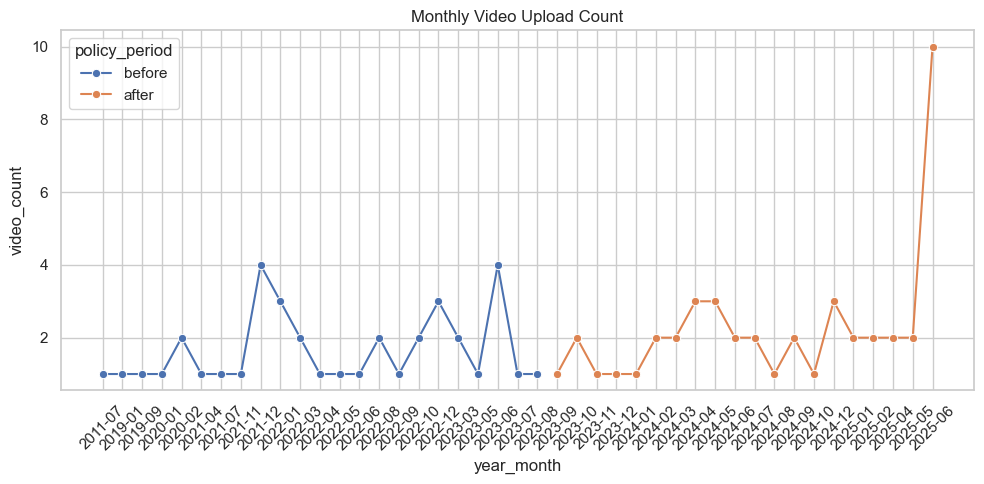

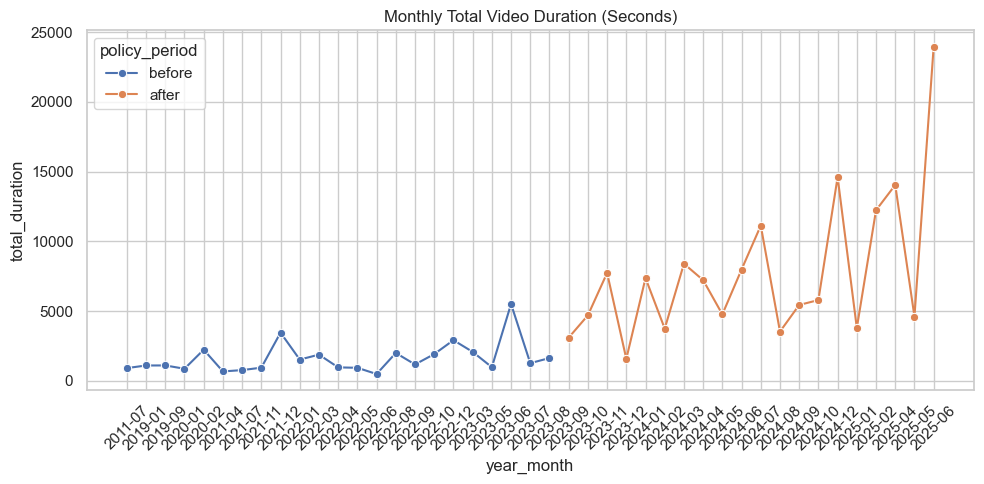

In [8]:
# 📊 Task 1: Policy Impact on Upload Volume & Duration

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Load processed data
df = pd.read_parquet("../data/processed/processed_videos.parquet")

# Create "policy_period" label
df["policy_period"] = df["after_policy"].map({True: "after", False: "before"})

# Group by year_month and policy period
monthly_stats = df.groupby(["year_month", "policy_period"]).agg(
    video_count=("bv", "count"),
    total_duration=("duration", "sum")
).reset_index()

# Plot: Monthly video count
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_stats, x="year_month", y="video_count", hue="policy_period", marker="o")
plt.title("Monthly Video Upload Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Monthly total duration
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_stats, x="year_month", y="total_duration", hue="policy_period", marker="o")
plt.title("Monthly Total Video Duration (Seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
